**GAN Training**

In [13]:
import os
import kagglehub
import shutil
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Download dataset using KaggleHub
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
print("Path to dataset files:", path)

# Function to convert images to JPEG
def convert_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, _, files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if img.mode not in ("RGB", "L"):
                        img = img.convert("RGB")
                    relative_path = os.path.relpath(root, input_dir)
                    save_dir = os.path.join(output_dir, relative_path)
                    os.makedirs(save_dir, exist_ok=True)
                    save_path = os.path.join(save_dir, f"{os.path.splitext(file)[0]}.jpg")
                    img.save(save_path, "JPEG")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Function to move processed images back to original directory
def move_processed_images(output_dir, original_dir):
    for root, _, files in os.walk(output_dir):
        for file in files:
            src_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, output_dir)
            dest_dir = os.path.join(original_dir, relative_path)
            dest_path = os.path.join(dest_dir, file)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(src_path, dest_path)

# Function to resize images
def resize_images(input_dir, output_dir, size=(256, 256)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(category_path, filename)
                output_path = os.path.join(output_category_path, filename)
                try:
                    img = Image.open(img_path)
                    img = img.resize(size)
                    img.save(output_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Convert and resize images
input_directory = "/root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset"  # Correct path
output_directory = "/content/processed_dataset"
convert_images(input_directory, output_directory)
move_processed_images(output_directory, input_directory)
shutil.rmtree(output_directory)
resize_images(input_directory, output_directory)

# PyTorch Dataset class
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Iterate through categories and collect image paths
        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):  # Ensure it's a directory
                for img_name in os.listdir(category_path):
                    img_path = os.path.join(category_path, img_name)
                    if img_path.endswith(".jpg") or img_path.endswith(".png"):  # Only consider image files
                        self.image_paths.append(img_path)

        # Check if any image paths were found
        print(f"Found {len(self.image_paths)} images in the dataset.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Apply transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create dataset and dataloader
dataset = WeatherDataset(root_dir=input_directory, transform=transform)
print(f"Dataset size: {len(dataset)}")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define Generator and Discriminator models
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 256 * 256),  # Output image size
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, z):
        return self.main(z).view(-1, 3, 256, 256)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(3 * 256 * 256, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability of real/fake
        )

    def forward(self, img):
        return self.main(img.view(img.size(0), -1))

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Create directory for generated images
generated_images_dir = "generated_images"
if not os.path.exists(generated_images_dir):
    os.makedirs(generated_images_dir)

# Training loop
epochs = 100
noise_dim = 100

for epoch in range(epochs):
    for real_imgs in tqdm(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        real_outputs = D(real_imgs)
        real_loss = criterion(real_outputs, real_labels)

        noise = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = G(noise)
        fake_outputs = D(fake_imgs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = D(fake_imgs)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

    # Print losses after each epoch
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample_noise = torch.randn(16, noise_dim).to(device)
            generated_images = G(sample_noise).cpu()
            # Save images
            torchvision.utils.save_image(generated_images,
                                         os.path.join(generated_images_dir, f"generated_epoch_{epoch+1}.png"),
                                         normalize=True)

# After training is done, you can check the `generated_images` folder for saved images.


Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3
Found 6862 images in the dataset.
Dataset size: 6862


100%|██████████| 215/215 [00:45<00:00,  4.73it/s]


Epoch [1/100] | D Loss: 0.5675156712532043 | G Loss: 1.0791218280792236


100%|██████████| 215/215 [00:45<00:00,  4.75it/s]


Epoch [2/100] | D Loss: 0.5459789037704468 | G Loss: 1.0061594247817993


100%|██████████| 215/215 [00:45<00:00,  4.71it/s]


Epoch [3/100] | D Loss: 0.4922837018966675 | G Loss: 1.2020128965377808


 40%|███▉      | 85/215 [00:17<00:27,  4.73it/s]


KeyboardInterrupt: 

In [14]:
import os
import kagglehub
import shutil
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training

# Download dataset using KaggleHub
path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
print("Path to dataset files:", path)

# Function to convert images to JPEG
def convert_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, _, files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if img.mode not in ("RGB", "L"):
                        img = img.convert("RGB")
                    relative_path = os.path.relpath(root, input_dir)
                    save_dir = os.path.join(output_dir, relative_path)
                    os.makedirs(save_dir, exist_ok=True)
                    save_path = os.path.join(save_dir, f"{os.path.splitext(file)[0]}.jpg")
                    img.save(save_path, "JPEG")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Function to resize images
def resize_images(input_dir, output_dir, size=(256, 256)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for filename in os.listdir(category_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(category_path, filename)
                output_path = os.path.join(output_category_path, filename)
                try:
                    img = Image.open(img_path)
                    img = img.resize(size)
                    img.save(output_path)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Convert and resize images
input_directory = "/root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset"  # Correct path
output_directory = "/content/processed_dataset"
convert_images(input_directory, output_directory)
shutil.rmtree(output_directory)
resize_images(input_directory, output_directory)

# PyTorch Dataset class
class WeatherDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Iterate through categories and collect image paths
        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):  # Ensure it's a directory
                for img_name in os.listdir(category_path):
                    img_path = os.path.join(category_path, img_name)
                    if img_path.endswith(".jpg") or img_path.endswith(".png"):  # Only consider image files
                        self.image_paths.append(img_path)

        # Check if any image paths were found
        print(f"Found {len(self.image_paths)} images in the dataset.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Apply transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create dataset and dataloader with optimizations
dataset = WeatherDataset(root_dir=input_directory, transform=transform)
print(f"Dataset size: {len(dataset)}")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)  # Increase num_workers

# Define Generator and Discriminator models
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 256 * 256),  # Output image size
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, z):
        return self.main(z).view(-1, 3, 256, 256)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(3 * 256 * 256, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability of real/fake
        )

    def forward(self, img):
        return self.main(img.view(img.size(0), -1))

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(noise_dim=100).to(device)
D = Discriminator().to(device)

# Mixed Precision Training: Automatic Cast for FP16
scaler = GradScaler()

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Create directory for generated images
generated_images_dir = "generated_images"
if not os.path.exists(generated_images_dir):
    os.makedirs(generated_images_dir)

# Training loop
epochs = 100
noise_dim = 100

for epoch in range(epochs):
    for real_imgs in tqdm(dataloader):
        real_imgs = real_imgs.to(device, non_blocking=True)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        real_outputs = D(real_imgs)
        real_loss = criterion(real_outputs, real_labels)

        noise = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = G(noise)
        fake_outputs = D(fake_imgs.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # Train Generator
        optimizer_G.zero_grad()
        fake_outputs = D(fake_imgs)
        g_loss = criterion(fake_outputs, real_labels)
        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

    # Print losses after each epoch
    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample_noise = torch.randn(16, noise_dim).to(device)
            generated_images = G(sample_noise).cpu()
            # Save images
            torchvision.utils.save_image(generated_images,
                                         os.path.join(generated_images_dir, f"generated_epoch_{epoch+1}.png"),
                                         normalize=True)

# After training is done, you can check the `generated_images` folder for saved images.


Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3
Found 6862 images in the dataset.
Dataset size: 6862


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-14-677c9840e5c6>:149: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
100%|██████████| 215/215 [00:50<00:00,  4.26it/s]


Epoch [1/100] | D Loss: 0.6205664873123169 | G Loss: 0.9410693645477295


100%|██████████| 215/215 [00:49<00:00,  4.34it/s]


Epoch [2/100] | D Loss: 0.45813244581222534 | G Loss: 1.1606358289718628


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [3/100] | D Loss: 1.1022945642471313 | G Loss: 1.2863928079605103


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [4/100] | D Loss: 0.5134783387184143 | G Loss: 1.469570517539978


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [5/100] | D Loss: 0.37538817524909973 | G Loss: 1.5564838647842407


100%|██████████| 215/215 [00:49<00:00,  4.35it/s]


Epoch [6/100] | D Loss: 1.0920134782791138 | G Loss: 1.527693271636963


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [7/100] | D Loss: 1.2333920001983643 | G Loss: 0.9100421071052551


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [8/100] | D Loss: 0.4287271499633789 | G Loss: 2.5109333992004395


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [9/100] | D Loss: 0.6944147944450378 | G Loss: 3.0210044384002686


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [10/100] | D Loss: 0.39033037424087524 | G Loss: 1.8682788610458374


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [11/100] | D Loss: 0.9778723120689392 | G Loss: 2.736415386199951


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [12/100] | D Loss: 0.7572320699691772 | G Loss: 2.874127149581909


100%|██████████| 215/215 [00:49<00:00,  4.34it/s]


Epoch [13/100] | D Loss: 1.3966114521026611 | G Loss: 3.251910924911499


100%|██████████| 215/215 [00:50<00:00,  4.28it/s]


Epoch [14/100] | D Loss: 0.9587600231170654 | G Loss: 2.297146797180176


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [15/100] | D Loss: 0.7289493680000305 | G Loss: 2.6295504570007324


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [16/100] | D Loss: 0.6109909415245056 | G Loss: 2.140385627746582


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [17/100] | D Loss: 0.8646401762962341 | G Loss: 1.9410624504089355


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [18/100] | D Loss: 1.0816749334335327 | G Loss: 1.7102776765823364


100%|██████████| 215/215 [00:49<00:00,  4.36it/s]


Epoch [19/100] | D Loss: 1.378434419631958 | G Loss: 2.5506772994995117


100%|██████████| 215/215 [00:50<00:00,  4.25it/s]


Epoch [20/100] | D Loss: 1.030953288078308 | G Loss: 2.2797181606292725


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [21/100] | D Loss: 0.8538069725036621 | G Loss: 1.6020699739456177


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [22/100] | D Loss: 1.2103019952774048 | G Loss: 2.5941238403320312


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [23/100] | D Loss: 1.044158697128296 | G Loss: 2.1482796669006348


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [24/100] | D Loss: 0.7098015546798706 | G Loss: 2.372060537338257


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [25/100] | D Loss: 1.0647313594818115 | G Loss: 1.720709204673767


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [26/100] | D Loss: 1.1031107902526855 | G Loss: 1.5948392152786255


100%|██████████| 215/215 [00:50<00:00,  4.27it/s]


Epoch [27/100] | D Loss: 1.0094201564788818 | G Loss: 1.9624168872833252


100%|██████████| 215/215 [00:47<00:00,  4.50it/s]


Epoch [28/100] | D Loss: 1.0231462717056274 | G Loss: 1.7414696216583252


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [29/100] | D Loss: 0.768234372138977 | G Loss: 1.6454951763153076


100%|██████████| 215/215 [00:48<00:00,  4.41it/s]


Epoch [30/100] | D Loss: 0.9177594780921936 | G Loss: 1.606773853302002


100%|██████████| 215/215 [00:49<00:00,  4.36it/s]


Epoch [31/100] | D Loss: 1.3881492614746094 | G Loss: 1.5537606477737427


100%|██████████| 215/215 [00:49<00:00,  4.30it/s]


Epoch [32/100] | D Loss: 1.2759052515029907 | G Loss: 1.3948296308517456


100%|██████████| 215/215 [00:49<00:00,  4.39it/s]


Epoch [33/100] | D Loss: 1.2074055671691895 | G Loss: 1.4334089756011963


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [34/100] | D Loss: 1.1523892879486084 | G Loss: 1.3940914869308472


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [35/100] | D Loss: 0.9473468065261841 | G Loss: 2.0004823207855225


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [36/100] | D Loss: 1.5075984001159668 | G Loss: 1.4829062223434448


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [37/100] | D Loss: 0.99506676197052 | G Loss: 1.1889034509658813


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [38/100] | D Loss: 1.0237586498260498 | G Loss: 1.3979661464691162


100%|██████████| 215/215 [00:49<00:00,  4.34it/s]


Epoch [39/100] | D Loss: 1.187620997428894 | G Loss: 2.2667760848999023


100%|██████████| 215/215 [00:49<00:00,  4.31it/s]


Epoch [40/100] | D Loss: 0.9666779041290283 | G Loss: 1.2770817279815674


100%|██████████| 215/215 [00:48<00:00,  4.47it/s]


Epoch [41/100] | D Loss: 0.8875926733016968 | G Loss: 1.6449940204620361


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [42/100] | D Loss: 1.1693233251571655 | G Loss: 1.7670862674713135


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [43/100] | D Loss: 1.4628779888153076 | G Loss: 1.6334575414657593


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [44/100] | D Loss: 1.3631893396377563 | G Loss: 1.580889344215393


100%|██████████| 215/215 [00:49<00:00,  4.31it/s]


Epoch [45/100] | D Loss: 0.7001583576202393 | G Loss: 2.197593927383423


100%|██████████| 215/215 [00:49<00:00,  4.31it/s]


Epoch [46/100] | D Loss: 1.7923579216003418 | G Loss: 1.7317020893096924


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [47/100] | D Loss: 0.7716891765594482 | G Loss: 1.9909100532531738


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [48/100] | D Loss: 0.9134558439254761 | G Loss: 1.4042432308197021


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [49/100] | D Loss: 1.2144609689712524 | G Loss: 1.9442025423049927


100%|██████████| 215/215 [00:49<00:00,  4.39it/s]


Epoch [50/100] | D Loss: 0.8865575790405273 | G Loss: 1.4546650648117065


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [51/100] | D Loss: 1.0074692964553833 | G Loss: 1.6905790567398071


100%|██████████| 215/215 [00:49<00:00,  4.33it/s]


Epoch [52/100] | D Loss: 0.9944902658462524 | G Loss: 1.9382548332214355


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [53/100] | D Loss: 1.0627518892288208 | G Loss: 1.431334376335144


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [54/100] | D Loss: 1.0844968557357788 | G Loss: 1.3117835521697998


100%|██████████| 215/215 [00:49<00:00,  4.39it/s]


Epoch [55/100] | D Loss: 1.1022957563400269 | G Loss: 1.4744716882705688


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [56/100] | D Loss: 1.639932632446289 | G Loss: 1.724790334701538


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [57/100] | D Loss: 1.3592551946640015 | G Loss: 1.6466385126113892


100%|██████████| 215/215 [00:49<00:00,  4.32it/s]


Epoch [58/100] | D Loss: 1.410154104232788 | G Loss: 1.3850528001785278


100%|██████████| 215/215 [00:49<00:00,  4.36it/s]


Epoch [59/100] | D Loss: 1.230287790298462 | G Loss: 1.4081453084945679


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [60/100] | D Loss: 1.1182398796081543 | G Loss: 1.2775923013687134


100%|██████████| 215/215 [00:49<00:00,  4.36it/s]


Epoch [61/100] | D Loss: 0.7679470777511597 | G Loss: 1.8266160488128662


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [62/100] | D Loss: 1.4470739364624023 | G Loss: 1.2078723907470703


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [63/100] | D Loss: 1.0610302686691284 | G Loss: 1.5019742250442505


100%|██████████| 215/215 [00:49<00:00,  4.32it/s]


Epoch [64/100] | D Loss: 1.2475244998931885 | G Loss: 1.6380962133407593


100%|██████████| 215/215 [00:49<00:00,  4.36it/s]


Epoch [65/100] | D Loss: 0.9249340295791626 | G Loss: 1.7695741653442383


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [66/100] | D Loss: 0.9981733560562134 | G Loss: 1.3189880847930908


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [67/100] | D Loss: 1.0964140892028809 | G Loss: 1.1665836572647095


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [68/100] | D Loss: 1.0595526695251465 | G Loss: 1.7403790950775146


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [69/100] | D Loss: 1.3971507549285889 | G Loss: 1.4236524105072021


100%|██████████| 215/215 [00:50<00:00,  4.29it/s]


Epoch [70/100] | D Loss: 0.9971796274185181 | G Loss: 1.3707219362258911


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [71/100] | D Loss: 1.3481314182281494 | G Loss: 1.697517991065979


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [72/100] | D Loss: 0.9686391949653625 | G Loss: 1.5203263759613037


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [73/100] | D Loss: 0.6293174028396606 | G Loss: 2.041614294052124


100%|██████████| 215/215 [00:48<00:00,  4.44it/s]


Epoch [74/100] | D Loss: 1.0670325756072998 | G Loss: 1.3143681287765503


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [75/100] | D Loss: 1.252638339996338 | G Loss: 1.6978329420089722


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [76/100] | D Loss: 1.2954307794570923 | G Loss: 1.783435583114624


100%|██████████| 215/215 [00:49<00:00,  4.34it/s]


Epoch [77/100] | D Loss: 1.1576714515686035 | G Loss: 1.8879843950271606


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [78/100] | D Loss: 1.0340523719787598 | G Loss: 1.725530982017517


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [79/100] | D Loss: 1.4278013706207275 | G Loss: 1.534145474433899


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [80/100] | D Loss: 0.9452505111694336 | G Loss: 1.4530479907989502


100%|██████████| 215/215 [00:48<00:00,  4.41it/s]


Epoch [81/100] | D Loss: 0.8576121926307678 | G Loss: 2.376521110534668


100%|██████████| 215/215 [00:49<00:00,  4.38it/s]


Epoch [82/100] | D Loss: 0.9403533935546875 | G Loss: 1.8028955459594727


100%|██████████| 215/215 [00:49<00:00,  4.33it/s]


Epoch [83/100] | D Loss: 0.9753557443618774 | G Loss: 1.6335970163345337


100%|██████████| 215/215 [00:50<00:00,  4.29it/s]


Epoch [84/100] | D Loss: 0.9668918251991272 | G Loss: 1.73557448387146


100%|██████████| 215/215 [00:48<00:00,  4.46it/s]


Epoch [85/100] | D Loss: 0.9376035928726196 | G Loss: 1.8737461566925049


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [86/100] | D Loss: 0.6021571755409241 | G Loss: 2.0989394187927246


100%|██████████| 215/215 [00:48<00:00,  4.43it/s]


Epoch [87/100] | D Loss: 1.0123522281646729 | G Loss: 1.53579580783844


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [88/100] | D Loss: 0.9118854999542236 | G Loss: 2.224980115890503


100%|██████████| 215/215 [00:48<00:00,  4.43it/s]


Epoch [89/100] | D Loss: 0.9367385506629944 | G Loss: 1.5063328742980957


100%|██████████| 215/215 [00:48<00:00,  4.39it/s]


Epoch [90/100] | D Loss: 0.8819025158882141 | G Loss: 1.5005439519882202


100%|██████████| 215/215 [00:49<00:00,  4.33it/s]


Epoch [91/100] | D Loss: 1.5139234066009521 | G Loss: 2.082178831100464


100%|██████████| 215/215 [00:49<00:00,  4.33it/s]


Epoch [92/100] | D Loss: 0.9055827260017395 | G Loss: 1.8554872274398804


100%|██████████| 215/215 [00:48<00:00,  4.43it/s]


Epoch [93/100] | D Loss: 1.1490538120269775 | G Loss: 2.106092691421509


100%|██████████| 215/215 [00:48<00:00,  4.45it/s]


Epoch [94/100] | D Loss: 0.8911846280097961 | G Loss: 2.0298211574554443


100%|██████████| 215/215 [00:48<00:00,  4.42it/s]


Epoch [95/100] | D Loss: 1.252983570098877 | G Loss: 1.808823585510254


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [96/100] | D Loss: 0.8943719267845154 | G Loss: 1.488791823387146


100%|██████████| 215/215 [00:49<00:00,  4.37it/s]


Epoch [97/100] | D Loss: 0.7549058198928833 | G Loss: 1.3957011699676514


100%|██████████| 215/215 [00:49<00:00,  4.32it/s]


Epoch [98/100] | D Loss: 0.8590012192726135 | G Loss: 1.8118098974227905


100%|██████████| 215/215 [00:49<00:00,  4.34it/s]


Epoch [99/100] | D Loss: 0.5940214991569519 | G Loss: 2.2508015632629395


100%|██████████| 215/215 [00:48<00:00,  4.40it/s]


Epoch [100/100] | D Loss: 0.9331861734390259 | G Loss: 1.589497685432434


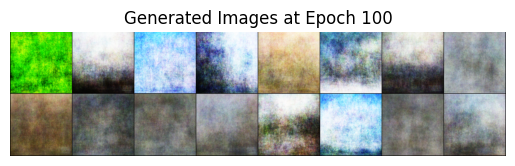

In [15]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Display the last generated image
latest_image_path = os.path.join(generated_images_dir, f"generated_epoch_{epochs}.png")
img = Image.open(latest_image_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Generated Images at Epoch {epochs}")
plt.show()


In [16]:
!pip install pytorch-fid

In [22]:
num_real_images = sum([len(files) for _, _, files in os.walk(input_directory)])
num_generated_images = sum([len(files) for _, _, files in os.walk(output_directory)])

print(f"Number of real images: {num_real_images}")
print(f"Number of generated images: {num_generated_images}")

if not os.path.exists(input_directory):
    raise ValueError(f"Real images path does not exist: {input_directory}")
if not os.path.exists(output_directory):
    raise ValueError(f"Generated images path does not exist: {output_directory}")




Number of real images: 6862
Number of generated images: 6862


In [26]:
from pytorch_fid import fid_score
import os

# Paths to the directories containing real and generated images
real_images_dir = input_directory
generated_images_dir = output_directory

# Count the number of images in each directory
num_real_images = sum([len(files) for _, _, files in os.walk(real_images_dir)])
num_generated_images = sum([len(files) for _, _, files in os.walk(generated_images_dir)])

# Debug: Print image counts for verification
print(f"Number of real images: {num_real_images}")
print(f"Number of generated images: {num_generated_images}")

# Validate that both directories contain images
if num_real_images == 0:
    raise ValueError(f"No images found in the real images directory: {real_images_dir}")
if num_generated_images == 0:
    raise ValueError(f"No images found in the generated images directory: {generated_images_dir}")

# Calculate the batch size based on the available image count, ensuring it is within a safe range
batch_size = min(32, num_real_images, num_generated_images)
batch_size = max(1, batch_size)  # Ensure it's at least 1

# Log the batch size just before computing FID
print(f"Calculated batch size: {batch_size}")

# Ensure the batch size is valid (greater than 0)
if batch_size <= 0:
    raise ValueError(f"Invalid batch size: {batch_size}. It should be a positive integer.")

# Compute the FID score using the real and generated image directories
try:
    fid_value = fid_score.calculate_fid_given_paths(
        [real_images_dir, generated_images_dir],
        batch_size=batch_size,
        device=device,
        dims=2048  # InceptionV3 feature vector dimension
    )
    print(f"FID Score: {fid_value}")
except ValueError as e:
    print(f"Error calculating FID: {e}")


Number of real images: 6862
Number of generated images: 6862
Calculated batch size: 32
Error calculating FID: batch_size should be a positive integer value, but got batch_size=0


In [27]:
torch.save(G.state_dict(), "generator.pth")
torch.save(D.state_dict(), "discriminator.pth")
print("Models saved successfully!")


Models saved successfully!


In [28]:
G.load_state_dict(torch.load("generator.pth"))
D.load_state_dict(torch.load("discriminator.pth"))
G.eval()  # Switch to evaluation mode
D.eval()


<ipython-input-28-55d3a1b1eabf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("generator.pth"))
<ipython-input-28-55d3a1b1eabf>:2: FutureWarn

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=196608, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

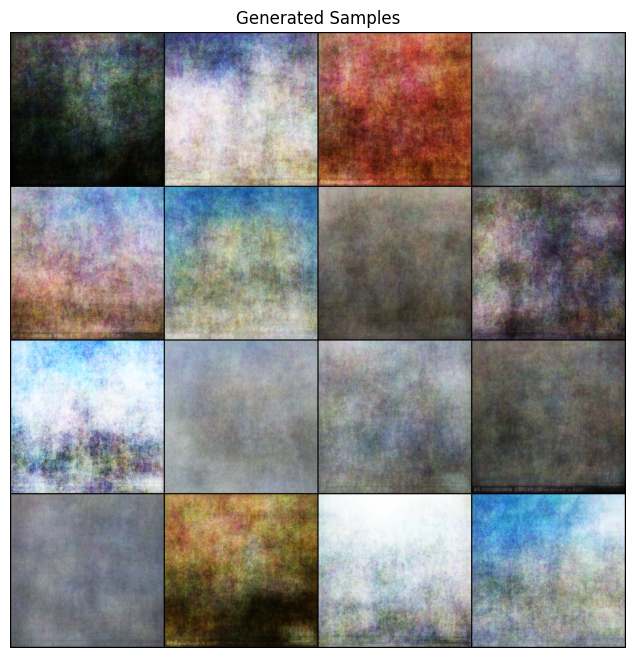

In [29]:
# Generate new images
num_samples = 16
noise = torch.randn(num_samples, noise_dim).to(device)
generated_images = G(noise).cpu()

# Display the generated images
grid = vutils.make_grid(generated_images, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Generated Samples")
plt.show()


In [30]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [32]:
# from pyngrok import ngrok

# # Start Streamlit server
# !streamlit run app.py &

# # Expose the port using ngrok
# public_url = ngrok.connect(port=8501)
# print(f"Public URL: {public_url}")


In [33]:
%%writefile app.py
import streamlit as st
from PIL import Image
import torch
from torchvision import transforms

# Load trained Generator
class Generator(torch.nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Linear(noise_dim, 256),
            torch.nn.ReLU(True),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(1024, 3 * 256 * 256),
            torch.nn.Tanh()
        )

    def forward(self, z):
        return self.main(z).view(-1, 3, 256, 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
G.load_state_dict(torch.load("generator.pth", map_location=device))
G.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define inverse normalization for display
inv_transform = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

# Streamlit UI
st.title("Weather Transformation GAN")
st.markdown("Upload an image and choose a weather type to transform your image!")

# File upload
uploaded_file = st.file_uploader("Choose an image", type=["jpg", "png"])
if uploaded_file is not None:
    user_image = Image.open(uploaded_file).convert("RGB")
    st.image(user_image, caption="Uploaded Image", use_column_width=True)

# Weather selection
weather_types = ["Snow", "Rain", "Fog", "Hail", "Lightning"]
selected_weather = st.selectbox("Select Weather Effect", weather_types)

# Generate and display
if st.button("Generate"):
    if uploaded_file is not None:
        # Prepare noise and generate
        noise = torch.randn(1, noise_dim).to(device)
        generated_image = G(noise).cpu().detach().squeeze(0)

        # Transform and display
        generated_image = inv_transform(generated_image)
        generated_image = transforms.ToPILImage()(generated_image.clamp(0, 1))
        st.image(generated_image, caption=f"Generated Image with {selected_weather}", use_column_width=True)
    else:
        st.error("Please upload an image first.")


Overwriting app.py


In [38]:
!apt-get install -y nodejs
!npm install -g localtunnel


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  javascript-common libc-ares2 libjs-highlight.js libnode72 nodejs-doc
Suggested packages:
  apache2 | lighttpd | httpd npm
The following NEW packages will be installed:
  javascript-common libc-ares2 libjs-highlight.js libnode72 nodejs nodejs-doc
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 13.7 MB of archives.
After this operation, 54.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 javascript-common all 11+nmu1 [5,936 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libjs-highlight.js all 9.18.5+dfsg1-1 [367 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-ares2 amd64 1.18.1-1ubuntu0.22.04.3 [45.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libnode72 amd64 12.22.9~dfsg-1ubuntu3.6 [10.8 MB]


In [39]:
!streamlit run app.py & npx localtunnel --port 8501

internal/modules/cjs/loader.js:818
  throw err;
  ^

Error: Cannot find module 'node:path'
Require stack:
- /tools/node/lib/node_modules/npm/lib/cli.js
- /tools/node/lib/node_modules/npm/bin/npx-cli.js
    at Function.Module._resolveFilename (internal/modules/cjs/loader.js:815:15)
    at Function.Module._load (internal/modules/cjs/loader.js:667:27)
    at Module.require (internal/modules/cjs/loader.js:887:19)
    at require (internal/modules/cjs/helpers.js:85:18)
    at Object.<anonymous> (/tools/node/lib/node_modules/npm/lib/cli.js:2:18)
    at Module._compile (internal/modules/cjs/loader.js:999:30)
    at Object.Module._extensions..js (internal/modules/cjs/loader.js:1027:10)
    at Module.load (internal/modules/cjs/loader.js:863:32)
    at Function.Module._load (internal/modules/cjs/loader.js:708:14)
    at Module.require (internal/modules/cjs/loader.js:887:19) {
  code: 'MODULE_NOT_FOUND',
  requireStack: [
    '/tools/node/lib/node_modules/npm/lib/cli.js',
    '/tools/node/lib/node

In [40]:
# Download the models to your local machine
from google.colab import files
files.download("generator.pth")
files.download("discriminator.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>